<a href="https://colab.research.google.com/github/hxh00138/ai-science-training-series/blob/main/session2_hw_Xiaohan_Hu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/argonne-lcf/ai-science-training-series.git
%cd ai-science-training-series/02_neural_networks_python/

Cloning into 'ai-science-training-series'...
remote: Enumerating objects: 2282, done.
remote: Total 2282 (delta 0), reused 0 (delta 0), pack-reused 2282
Receiving objects: 100% (2282/2282), 222.42 MiB | 24.60 MiB/s, done.
Resolving deltas: 100% (1120/1120), done.
Checking out files: 100% (272/272), done.
/content/ai-science-training-series/02_neural_networks_python


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# repeating the data prep from the previous notebook
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# EDIT: splitting training data into train and val because this is better practice than using test data to
# choose models/hyperparameters
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

x_train = x_train.astype(numpy.float32)
# EDIT: adding pre-processing to validation data 
x_val  = x_val.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_val  /= 255.
x_test  /= 255.

print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0], numpy.prod(x_train[0,:,:].shape))
x_val = x_val.reshape(x_val.shape[0], numpy.prod(x_val[0,:,:].shape))
x_test = x_test.reshape(x_test.shape[0], numpy.prod(x_test[0,:,:].shape))

print(x_train.shape)
y_train = y_train.astype(numpy.int32)
y_val  = y_val.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

print()
print('MNIST data loaded: train:',len(x_train),'val:',len(x_val), 'test:',len(x_test))
print('X_train:', x_train.shape)
print('y_train:', y_train.shape)

# one-hot encoding:
nb_classes = 10
y_train_onehot = tf.keras.utils.to_categorical(y_train, nb_classes)
y_val_onehot = tf.keras.utils.to_categorical(y_val, nb_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test, nb_classes)

11490434/11490434 [==============================] - 1s 0us/step
(40200, 28, 28)
(40200, 784)

MNIST data loaded: train: 40200 val: 19800 test: 10000
X_train: (40200, 784)
y_train: (40200,)


In [ ]:
# Here we import an implementation of a two-layer neural network 
# this code is based on pieces of the first assignment from Stanford's CSE231n course, 
# hosted at https://github.com/cs231n/cs231n.github.io with the MIT license
from fc_net import TwoLayerNet

In [ ]:
# a simple implementation of stochastic gradient descent
def sgd(model, gradients, learning_rate):
    for p, w in model.params.items():
        dw = gradients[p]
        new_weights = w - learning_rate * dw
        model.params[p] = new_weights

In [ ]:
# one training step
def learn(model, x_train, y_train_onehot, learning_rate):
    loss, gradients = model.loss(x_train, y_train_onehot)
    sgd(model, gradients, learning_rate)
    return loss

In [ ]:
def accuracy(model, x, true_values):
    scores = model.loss(x)
    predictions = numpy.argmax(scores, axis=1)
    N = predictions.shape[0]
    # EDIT: squeezing true_values from 2d to 1d speeds up this function
    true_values_1d = numpy.squeeze(true_values)
    acc = (true_values_1d == predictions).sum() / N
    return acc

In [ ]:
# EDIT: decided to track how long each epoch takes
import time

In [ ]:
# Here's an example training loop using this two-layer model. Can you do better? 

# EDIT: also track validation data
# EDIT: factoring this out into a function to make it easier to compare options
def training(learning_rate, batch_size, num_epochs, hidden_dim, weight_scale, x_train, y_train, y_train_onehot, x_val, y_val, y_val_onehot):
    num_features = x_train.shape[1] # this is the number of pixels
    nb_classes = y_train_onehot.shape[1]
    
    # The weights are initialized from a normal distribution with standard deviation weight_scale
    model = TwoLayerNet(input_dim=num_features, hidden_dim=hidden_dim, num_classes=nb_classes, weight_scale=weight_scale)
    
    num_examples_train = x_train.shape[0]
    num_batches_train = int(num_examples_train / batch_size)
    
    losses = numpy.zeros((num_batches_train*num_epochs,2)) # 1st column for training data, 2nd for validation data
    # EDIT: also track accuracy
    accuracies = numpy.zeros((num_batches_train*num_epochs,2)) 
    
    indices_train = numpy.arange(num_examples_train)
    num_examples_val = x_val.shape[0]
    indices_val = numpy.arange(num_examples_val)

    i = 0
    for epoch in range(0, num_epochs):
        start_epoch = time.time()
        # in each epoch, we loop over all of the training examples
        for step in range(0, num_batches_train):
            # grabbing the next training batch
            offset_train = step * batch_size
            batch_range_train = range(offset_train, offset_train+batch_size)
            x_train_batch = x_train[batch_range_train, :]
            # EDIT: keep around non-onehot labels as well for accuracy calculation
            y_train_onehot_batch = y_train_onehot[batch_range_train,:]
            y_train_batch = y_train[batch_range_train,numpy.newaxis]

            # one approach: grab a random validation batch (random offset into number of validation examples)
            offset_val = numpy.random.randint(low=0, high=num_examples_val-batch_size)
            batch_range_val = range(offset_val, offset_val+batch_size)
            x_val_batch = x_val[batch_range_val, :]
            y_val_onehot_batch = y_val_onehot[batch_range_val,:]
            y_val_batch = y_val[batch_range_val,numpy.newaxis]

            # feed the next batch in to do one sgd step
            loss_train = learn(model, x_train_batch, y_train_onehot_batch, learning_rate)

            # check training & validation loss & accuracy
            losses[i,0] = loss_train
            
            # could save time by commenting out the next three lines and only tracking at the epoch level
            accuracies[i,0] = accuracy(model, x_train_batch, y_train_batch)
            losses[i,1], _ = model.loss(x_val_batch, y_val_onehot_batch)
            accuracies[i,1] = accuracy(model, x_val_batch, y_val_batch)
            i += 1

        # slower, so we're only doing this once per epoch: checking accuracy on all of the data at once
        acc_train = accuracy(model, x_train, y_train)
        acc_val = accuracy(model, x_val, y_val)
        
        # reshuffle the data so that we get a new set of batches
        numpy.random.shuffle(indices_train)
        x_train = x_train[indices_train,:]
        y_train = y_train[indices_train] # keep this shuffled the same way for use in accuracy calculation
        y_train_onehot = y_train_onehot[indices_train,:]

        numpy.random.shuffle(indices_val)
        x_val = x_val[indices_val,:]
        y_val = y_val[indices_val] 
        y_val_onehot = y_val_onehot[indices_val,:]
        end_epoch = time.time()
        time_this_epoch = end_epoch - start_epoch
        print("epoch %d took %.1f seconds, training loss %.5f (last batch), training accuracy %.3f, validation accuracy %.3f" % (epoch, time_this_epoch, loss_train, acc_train, acc_val))
    return losses, accuracies, model


epoch 0 took 24.7 seconds, training loss 2.27602 (last batch), training accuracy 0.437, validation accuracy 0.435
epoch 1 took 26.3 seconds, training loss 2.23883 (last batch), training accuracy 0.593, validation accuracy 0.592
epoch 2 took 30.2 seconds, training loss 2.19529 (last batch), training accuracy 0.659, validation accuracy 0.654
epoch 3 took 24.7 seconds, training loss 2.14144 (last batch), training accuracy 0.688, validation accuracy 0.689
epoch 4 took 24.2 seconds, training loss 2.07640 (last batch), training accuracy 0.709, validation accuracy 0.707
epoch 5 took 26.3 seconds, training loss 1.99211 (last batch), training accuracy 0.724, validation accuracy 0.723
epoch 6 took 24.5 seconds, training loss 1.89289 (last batch), training accuracy 0.734, validation accuracy 0.733
epoch 7 took 25.7 seconds, training loss 1.78851 (last batch), training accuracy 0.741, validation accuracy 0.742
epoch 8 took 24.8 seconds, training loss 1.66847 (last batch), training accuracy 0.745, 

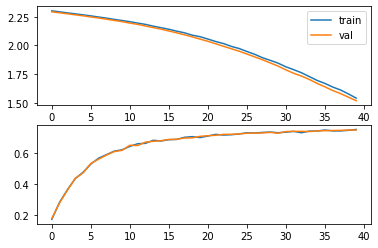

In [ ]:
# these are the hyperparameters we had in class
learning_rate = 0.1  
batch_size = 10000
num_epochs = 10
hidden_dim = 1000
weight_scale = .01
losses, accuracies, model = training(learning_rate, batch_size, num_epochs, hidden_dim, weight_scale, x_train, y_train, y_train_onehot, x_val, y_val, y_val_onehot)

# EDIT: plot training & val, loss & accuracy
plt.figure()
plt.subplot(2,1,1)
plt.plot(losses[:,0])
plt.plot(losses[:,1])
plt.legend(["train", "val"])

plt.subplot(2,1,2)
plt.plot(accuracies[:,0])
plt.plot(accuracies[:,1])

#By adjusting the learning rate and the dimension of the hidden layer, we can easily increase the accuracy from roughly 40% to 75%